<a href="https://colab.research.google.com/github/RenataTNT/geekbrains_tasks/blob/lesson3_insurance_case/Renata_Irnazarova_Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Построить модель градиентного бустинга для показателя частоты страховых убытков. Можно предобработать исходные данные, добавив дополнительные фичи. Также можно использовать различные методы для подбора гиперпараметров. Оценить результаты построенного классификатора, выявить возможные проблемы. Сравнить результаты с полученным ранее результатом с использованием Пуассоновской регрессии. Проанализировать результаты, предложить способы решения обнаруженных проблем и/или попробовать его улучшить.

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [0]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [4]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

Перекодируем переменные типа object с помощью числовых значений

In [0]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [6]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [7]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


Для переменных, содержащих более 2 значений, различия между которыми не могут упорядочены, используем фиктивные переменные (one-hot encoding).

In [8]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [9]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

In [0]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [11]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [0]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

Теперь, когда большинство переменных типа object обработаны, исключим их из набора данных за ненадобностью.

In [0]:
df = df.select_dtypes(exclude=['object'])

Также создадим такую переменную, как квадрат возраста.

In [14]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0,0,1,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0,1,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1,0,0,0,0,0,0,0,0,1,0,3249


Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [0]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [16]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,103609
2.0,3725
1.0,3675
3.0,2402
4.0,1140
5.0,441
6.0,128
7.0,26
8.0,6
9.0,2


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   LicAge                           115155 non-null  int64  
 2   Gender                           115155 non-null  int64  
 3   MariStat                         115155 non-null  int64  
 4   DrivAge                          115155 non-null  int64  
 5   HasKmLimit                       115155 non-null  int64  
 6   BonusMalus                       115155 non-null  int64  
 7   ClaimAmount                      115155 non-null  float64
 8   ClaimInd                         115155 non-null  int64  
 9   OutUseNb                         115155 non-null  float64
 10  RiskArea                         115155 non-null  float64
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [0]:
df.loc[df['ClaimsCount']==11]=10

Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [21]:
PoliciesByClamesCount=pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)
PoliciesByClamesCount

,Policies
0.0,103609
2.0,3725
1.0,3675
3.0,2402
4.0,1140
5.0,441
6.0,128
7.0,26
8.0,6
9.0,2


In [23]:
FreqCount = pd.DataFrame(PoliciesByClamesCount['Policies'].values/np.sum(PoliciesByClamesCount['Policies']), columns=['Freq'])
FreqCount

,Freq
0,0.899735
1,0.032348
2,0.031914
3,0.020859
4,0.009900
5,0.003830
6,0.001112
7,0.000226
8,0.000052
9,0.000017


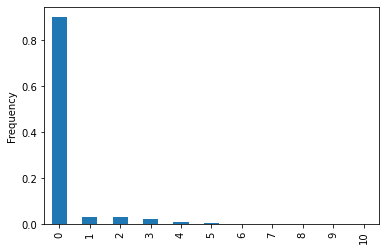

In [24]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему значения, равные (1-Freq)

In [0]:
df=df.merge(FreqCount,left_on='ClaimsCount',right_on=FreqCount.index, how='outer')

In [33]:
df['weight']=1-df['Freq']
df.tail()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq,ClaimsCount,weight,Freq
115150,0.079,170,0,0,33,0,50,80.922054,1,0.0,10.0,0,0,1,0,0,0,0,1,0,0,0,1089,8.0,0.999948,0.000052
115151,0.271,252,1,0,40,0,100,218.411782,1,0.0,11.0,0,1,0,0,0,0,0,0,1,0,0,1600,8.0,0.999948,0.000052
115152,0.499,515,0,0,61,0,95,2163.262840,1,0.0,11.0,0,1,0,0,0,0,0,0,1,0,0,3721,9.0,0.999983,0.000017
115153,0.250,57,1,0,39,0,118,1538.390937,1,3.0,11.0,0,1,0,0,0,0,0,0,1,0,0,1521,9.0,0.999983,0.000017
115154,10.000,10,10,10,10,10,10,10.000000,10,10.0,10.0,10,10,10,10,10,10,10,10,10,10,10,10,10.0,0.999991,0.000009


Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 1.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount','Freq','Exposure'], axis=1), df.ClaimsCount, test_size=0.3, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

Для оптимизации гиперпараметров можно воспользоваться различными методами. Попробуем GridSearchCV

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [165]:
len(y_train.unique())

11

In [0]:
sample_weights_data=x_train['weight'].values

In [0]:
x_train=x_train.drop(['weight'], axis=1)
x_valid=x_valid.drop(['weight'], axis=1)
x_test=x_test.drop(['weight'], axis=1)

In [0]:
estimator = XGBClassifier(
    objective= 'multi:softmax',
    num_class=len(y_train.unique()),
    nthread=4,
    seed=42,
    sample_weight=sample_weights_data
)

In [0]:
parameters = {
    'max_depth': [2, 3, 5],
    'n_estimators': [50, 100, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

In [0]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1_macro',
    cv = 5,
    verbose=True
)

In [200]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 104.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, num_class=11,
                                     objective='multi:softmax', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     sample_weight=array([0.10026486, 0.10026486, 0.10026486, ..., 0.10026486, 0.10026486,
       0.10026486]),
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_

In [201]:
print(grid_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=4, num_class=11, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1,
              sample_weight=array([0.10026486, 0.10026486, 0.10026486, ..., 0.10026486, 0.10026486,
       0.10026486]),
              scale_pos_weight=1, seed=42, silent=None, subsample=1,
              verbosity=1)


In [0]:
grid_search.best_estimator_=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=4, num_class=11, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1,
              sample_weight=sample_weights_data,
              scale_pos_weight=1, seed=42, silent=None, subsample=1,
              verbosity=1)

Далее обучим нашу модель с оптимальными параметрами

In [0]:
xgb_model=grid_search.best_estimator_

In [205]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=4, num_class=11, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1,
              sample_weight=array([0.10026486, 0.10026486, 0.10026486, ..., 0.10026486, 0.10026486,
       0.10026486]),
              scale_pos_weight=1, seed=42, silent=None, subsample=1,
              verbosity=1)

In [0]:
y_train_pred=xgb_model.predict(x_train)
y_valid_pred=xgb_model.predict(x_valid)
y_test_pred=xgb_model.predict(x_test)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [207]:
accuracy_score(y_train, y_train_pred), accuracy_score(y_valid, y_valid_pred), accuracy_score(y_test, y_test_pred)

(0.8993400158793172, 0.9052278121924391, 0.8986916753502373)

In [208]:
f1_score(y_train, y_train_pred, average='macro'), f1_score(y_valid, y_valid_pred, average='micro'), f1_score(y_test, y_test_pred, average='macro')

(0.32147269374473947, 0.9052278121924391, 0.10518256533257447)

In [0]:
confmatrix_train = confusion_matrix(y_train, y_train_pred)
confmatrix_valid = confusion_matrix(y_valid, y_valid_pred)
confmatrix_test = confusion_matrix(y_test, y_test_pred)

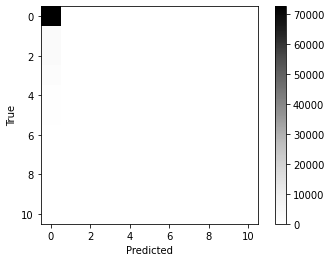

In [210]:

plt.imshow(confmatrix_train, cmap='Greys')


plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

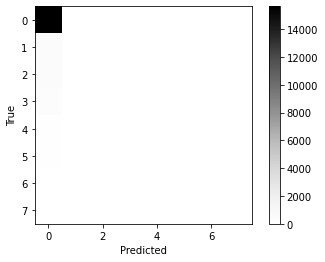

In [211]:
plt.imshow(confmatrix_valid, cmap='Greys')

plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

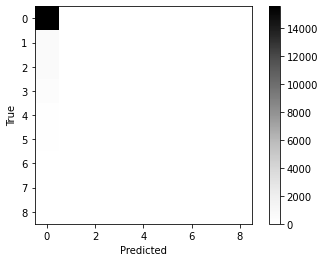

In [212]:
plt.imshow(confmatrix_test, cmap='Greys')

plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [213]:
pd.DataFrame(pd.Series(y_train_pred).value_counts(), columns=['Policies'])

,Policies
0.0,80559
5.0,16
4.0,8
6.0,7
2.0,7
7.0,4
1.0,3
9.0,1
3.0,1
10.0,1


In [214]:
y_train.value_counts()

0.0     72445
2.0      2633
1.0      2586
3.0      1700
4.0       825
5.0       305
6.0        84
7.0        22
8.0         5
9.0         2
10.0        1
Name: ClaimsCount, dtype: int64

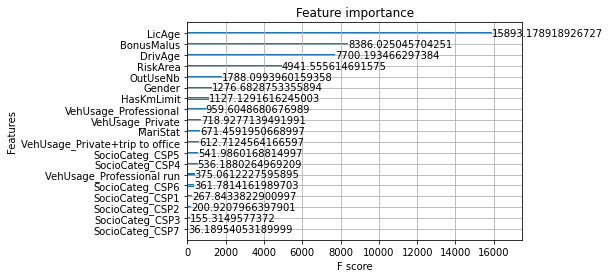

In [215]:
importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_model, importance_type=importance_type[0]); plt.show()

In [218]:
pd.DataFrame(pd.Series(y_test_pred).value_counts(), columns=['Policies'])

,Policies
0.0,17272
5.0,1
4.0,1


In [219]:
y_test.value_counts()

0.0    15526
1.0      579
2.0      562
3.0      363
4.0      151
5.0       65
6.0       24
7.0        3
8.0        1
Name: ClaimsCount, dtype: int64

In [220]:
17272/15526-1

0.11245652453948218

accuracy почти 90% на тесте, что, скоррее всего, неплохо для быстрой классификации потенциальной частоты страховых случаев. Возможно, стоит лучше поработать с балансом классов, т.к. модель отдала нулевому классу существенно больше претендентов (на 11% больше), чем есть на самом деле, а значит недооценивается раск ущерба